In [215]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from fuzzy_expert.variable import FuzzyVariable
from fuzzy_expert.rule import FuzzyRule

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# import some data to play with
iris = datasets.load_iris()

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import chi2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm

from scipy.stats import ttest_ind
from tabulate import tabulate

# from dtreeviz.trees import dtreeviz

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns', None)
np.random.seed(2)

In [26]:
random_seed = 2
y_type = 'NSP'

In [27]:
df_data = pd.read_excel('CTG.xlsx', sheet_name="Data", header=1)
df_data = df_data[0:-3]
df_data=df_data.set_index(np.arange(2126)+1)

df = pd.read_excel('CTG.xlsx', sheet_name="Raw Data")
df = df[1:-3] # delete empty rows
df = df.drop(['FileName'], axis=1) # delete FileName column
df = df.drop(['SegFile'], axis=1) # delete SegFile column
df = df.drop(['LBE'], axis=1) # delete LBE column (repeated LB column)
df = df.drop(['DR'], axis=1) # delete DR column (everything is zero)
a= df_data['AC.1']
df['AC'] = df_data['AC.1']
df['FM'] = df_data['FM.1']
df['UC'] = df_data['UC.1']
df['DL'] = df_data['DL.1']
df['DS'] = df_data['DS.1']
df['DP'] = df_data['DP.1']

df = df[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',  'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 
         'Median', 'Variance', 'Tendency', 'CLASS', 'NSP']]

df['Nmax'] = df['Nmax'].astype(int)
df['Nzeros'] = df['Nzeros'].astype(int)
df['CLASS'] = df['CLASS'].astype(int)
df['NSP'] = df['NSP'].astype(int)

In [30]:
df = df[['ALTV', 'Variance', 'ASTV', 'NSP']]
df.head()

,ALTV,Variance,ASTV,NSP
1,43.0,73.0,73.0,2
2,0.0,12.0,17.0,1
3,0.0,13.0,16.0,1
4,0.0,13.0,16.0,1
5,0.0,11.0,16.0,1


In [184]:
profile = ProfileReport(df[['ALTV', 'Variance', 'ASTV', 'NSP']], title="Pandas Profiling Report", vars={"num": {"low_categorical_threshold": 0}})
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [201]:
data = df['NSP']#[df['ALTV']!=0]

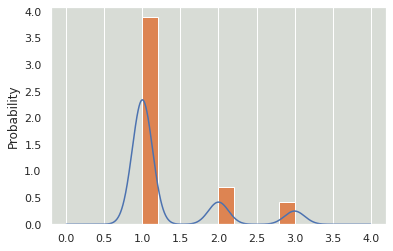

In [202]:
fig, ax = plt.subplots()
data.plot.kde(ax=ax, legend=False)
data.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

/home/karol/miniconda3/envs/ur/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NSP', ylabel='Density'>

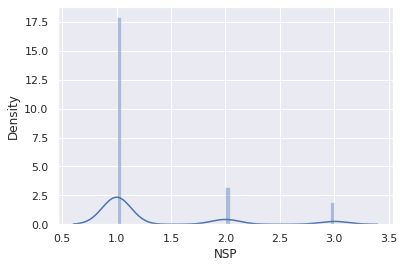

In [203]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(data)

In [ ]:
FuzzyVariable(
        universe_range=(0, 100),
        terms={
            "One": [(1.25, 1), (1.75, 0)],
            "Two": [(1.25, 0), (1.75, 1), (2.25, 1), (2.75,0)],
            "Three": [(2.25, 0), (2.75, 1)],
        },
    ),

In [ ]:
data.min()

12.0

In [172]:
print(2126/3)
print(df.shape)
print()
print(df['ALTV'][df['ALTV']<1].shape)
print(df['ALTV'][df['ALTV']<16].shape)
print()
print(df['Variance'][df['Variance']<4].shape)
print(df['Variance'][df['Variance']<16].shape)

708.6666666666666
(2126, 4)

(1240,)
(1684,)

(762,)
(1412,)


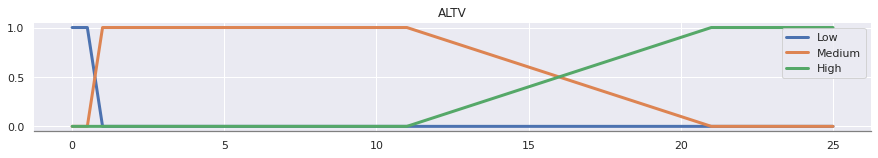

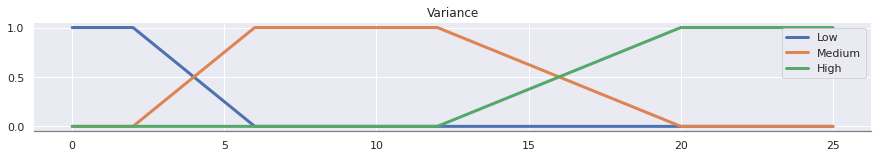

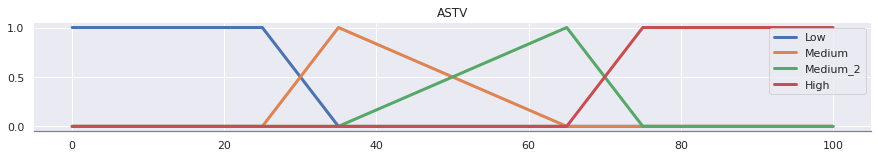

In [213]:
variables = {
    "ALTV": FuzzyVariable(
        universe_range=(0, 25),
        terms={
            "Low": [(0.5, 1), (1, 0)],
            "Medium": [(0.5, 0), (1, 1), (11,1), (21,0)],
            "High": [(11, 0), (21, 1)],
        },
    ),
    "Variance": FuzzyVariable(
        universe_range=(0, 25),
        terms={
            "Low": [(2, 1), (6, 0)], #żeby się w 4 przecinąływ połowie
            "Medium": [(2, 0), (6, 1), (12,1), (20,0)],
            "High": [(12, 0), (20, 1)], #żeby się w 16 przecinąływ połowie
        },
    ),
    "ASTV": FuzzyVariable(
        universe_range=(0, 100),
        terms={
            "Low": [(25, 1), (35, 0)],
            "Medium": [(25, 0), (35, 1), (65,0)],
            "Medium_2": [(35, 0), (65, 1), (75,0)],
            "High": [(65, 0), (75, 1)],
        },
    ),
    "NSP": FuzzyVariable(
        universe_range=(1, 3),
        terms={
            "N": [(1.25, 1), (1.75, 0)],
            "S": [(1.25, 0), (1.75, 1), (2.25, 1), (2.75,0)],
            "P": [(2.25, 0), (2.75, 1)],
        },
    ),
}

plt.figure(figsize=(15, 2))
plt.title('ALTV')
variables["ALTV"].plot()
plt.figure(figsize=(15, 2))
plt.title('Variance')
variables["Variance"].plot()
plt.figure(figsize=(15, 2))
plt.title('ASTV')
variables["ASTV"].plot()
# plt.figure(figsize=(15, 2))
# plt.title('NSP')
# variables["NSP"].plot()

In [216]:
rules = [
    FuzzyRule(
        premise=[
            ("ASTV", "Medium"),
            ("AND", "Variance", "Medium"),
            ("AND", "ALTV", "High"),
        ],
        consequence=[("NSP", "S")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "Medium"),
            ("AND", "Variance", "Medium"),
            ("AND", "ALTV", "Low"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "Low"),
            ("AND", "Variance", "High"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "Medium"),
            ("AND", "Variance", "High"),
        ],
        consequence=[("NSP", "P")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "Variance", "Medium"),
            ("AND", "ALTV", "Low"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "Variance", "High"),
            ("AND", "ALTV", "Low"),
        ],
        consequence=[("NSP", "P")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "ALTV", "Medium"),
        ],
        consequence=[("NSP", "S")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "ALTV", "High"),
        ],
        consequence=[("NSP", "P")],
    ),
]

print(rules[0])
print()
print(rules[1])

IF  ASTV IS Medium
    AND Variance IS Medium
    AND ALTV IS High
THEN
    NSP IS S
CF = 1.00
Threshold-CF = 0.00


IF  ASTV IS Medium
    AND Variance IS Medium
    AND ALTV IS Low
THEN
    NSP IS N
CF = 1.00
Threshold-CF = 0.00



In [225]:
df.sample(5)

,ALTV,Variance,ASTV,NSP
766,62.0,0.0,76.0,2
863,13.0,2.0,36.0,1
750,53.0,1.0,81.0,3
1953,0.0,80.0,60.0,3
323,39.0,6.0,56.0,2


In [237]:
from fuzzy_expert.inference import DecompositionalInference

instance = 323

model = DecompositionalInference(
    and_operator="min",
    or_operator="max",
    implication_operator="Rc",
    composition_operator="max-min",
    production_link="max",
    defuzzification_operator="cog",
)

results = model(
    variables=variables,
    rules=rules,
    ALTV=df.loc[instance][0],
    Variance=df.loc[instance][1],
    ASTV=df.loc[instance][2],
)

In [252]:
correct = 0
ys=[]
for i in range(df.shape[0]):
    results = model(
        variables=variables,
        rules=rules,
        ALTV=df.iloc[i][0],
        Variance=df.iloc[i][1],
        ASTV=df.iloc[i][2],
    )
    y = df.iloc[i][3]
    pred = results[0]['NSP']
    if y==pred:
        correct+=1
    ys.append(np.round(pred))
correct/df.shape[0]

0.11618062088428975

In [245]:
df.iloc[0][3] == results[0]['NSP']

True

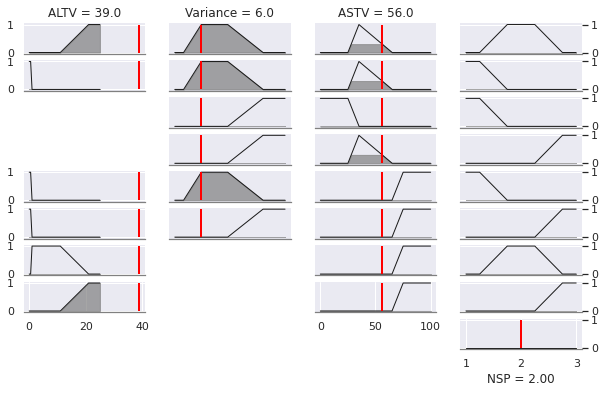

In [232]:
plt.figure(figsize=(10, 6))
model.plot(
    variables=variables,
    rules=rules,
    ALTV=df.loc[instance][0],
    Variance=df.loc[instance][1],
    ASTV=df.loc[instance][2],
)

In [235]:
df.describe()

,ALTV,Variance,ASTV,NSP
count,2126.00000,2126.000000,2126.000000,2126.000000
mean,9.84666,18.808090,46.990122,1.304327
std,18.39688,28.977636,17.192814,0.614377
min,0.00000,0.000000,12.000000,1.000000
25%,0.00000,2.000000,32.000000,1.000000
50%,0.00000,7.000000,49.000000,1.000000
75%,11.00000,24.000000,61.000000,1.000000
max,91.00000,269.000000,87.000000,3.000000


In [236]:
from ipywidgets import interact, widgets

def demo(ALTV, Variance, ASTV):
    plt.figure(figsize=(10,6))
    model.plot(
        variables=variables,
        rules=rules,
        ALTV=ALTV,
        Variance=Variance,
        ASTV=ASTV,
    )

interact(
    demo,
    ALTV=widgets.FloatSlider(min=0, max=100),
    Variance=widgets.FloatSlider(min=0, max=300),
    ASTV=widgets.FloatSlider(min=0, max=100),
)

interactive(children=(FloatSlider(value=0.0, description='ALTV'), FloatSlider(value=0.0, description='Variance…

<function __main__.demo(ALTV, Variance, ASTV)>